In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class ModelTrainer:
    def __init__(self, model, train_dataset, test_dataset, device, learning_rate=0.01, lambda_l2=0.0001, num_epochs=40):
        self.model = model.to(device)
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
        self.device = device
        self.learning_rate = learning_rate
        self.lambda_l2 = lambda_l2
        self.num_epochs = num_epochs
        self.y_true = []
        self.y_pred = []
        self.criterion = nn.CrossEntropyLoss()
        
    def train_manual(self):
        """Train the model manually without using an optimizer."""
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                l2_reg = 0
                for param in self.model.parameters():
                    l2_reg += torch.sum(param ** 2)
                loss += self.lambda_l2 * l2_reg

                self.model.zero_grad()
                loss.backward()
                with torch.no_grad():
                    for param in self.model.parameters():
                        param -= self.learning_rate * param.grad

                running_loss += loss.item()

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {running_loss / len(self.train_loader):.4f}')

    def train_with_optimizer(self, optimizer):
        """Train the model using an optimizer."""
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Loss: {running_loss / len(self.train_loader):.4f}')

    def evaluate(self):
        """Evaluate the model on the test dataset."""
        self.model.eval()
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                self.y_true.extend(labels.cpu().numpy())
                self.y_pred.extend(predicted.cpu().numpy())


    def plot_confusion_matrix(self, model_name="Model"):
        """Plot the confusion matrix for the model's predictions."""

        conf_matrix = confusion_matrix(self.y_true, self.y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=self.train_dataset.classes, yticklabels=self.train_dataset.classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f"Confusion Matrix for Fashion-MNIST Classification for {model_name}")
        plt.show()
        conf_matrix[range(len(conf_matrix)), range(len(conf_matrix))] = 0
        most_confused = np.unravel_index(conf_matrix.argmax(), conf_matrix.shape)
        print(f'Two classes most confused with each other: {self.train_dataset.classes[most_confused[0]]} and {self.train_dataset.classes[most_confused[1]]}')


    def plot_weight_histograms(self, model_name="Model"):
        """Plot histograms of the model's layer weights."""

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(self.model.fc1.weight.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f"{model_name} - Input Layer Weights")

        plt.subplot(1, 2, 2)
        plt.hist(self.model.fc2.weight.detach().cpu().numpy().flatten(), bins=50)
        plt.title(f"{model_name} - Hidden Layer Weights")

        plt.show()


In [10]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Q1.1

In [11]:
class FashionMNISTNet(nn.Module):
    def __init__(self):
        super(FashionMNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
model_trainer = ModelTrainer(FashionMNISTNet(), train_dataset, test_dataset, device, learning_rate=0.01, lambda_l2=0.0001, num_epochs=20)

Epoch [1/20], Loss: 0.8043
Epoch [2/20], Loss: 0.6785
Epoch [3/20], Loss: 0.6167
Epoch [4/20], Loss: 0.5772
Epoch [5/20], Loss: 0.5490
Epoch [6/20], Loss: 0.5299
Epoch [7/20], Loss: 0.5132
Epoch [8/20], Loss: 0.5002
Epoch [9/20], Loss: 0.4877
Epoch [10/20], Loss: 0.4769
Epoch [11/20], Loss: 0.4682
Epoch [12/20], Loss: 0.4608
Epoch [13/20], Loss: 0.4554
Epoch [14/20], Loss: 0.4476
Epoch [15/20], Loss: 0.4419
Epoch [16/20], Loss: 0.4359
Epoch [17/20], Loss: 0.4330
Epoch [18/20], Loss: 0.4276
Epoch [19/20], Loss: 0.4238
Epoch [20/20], Loss: 0.4199


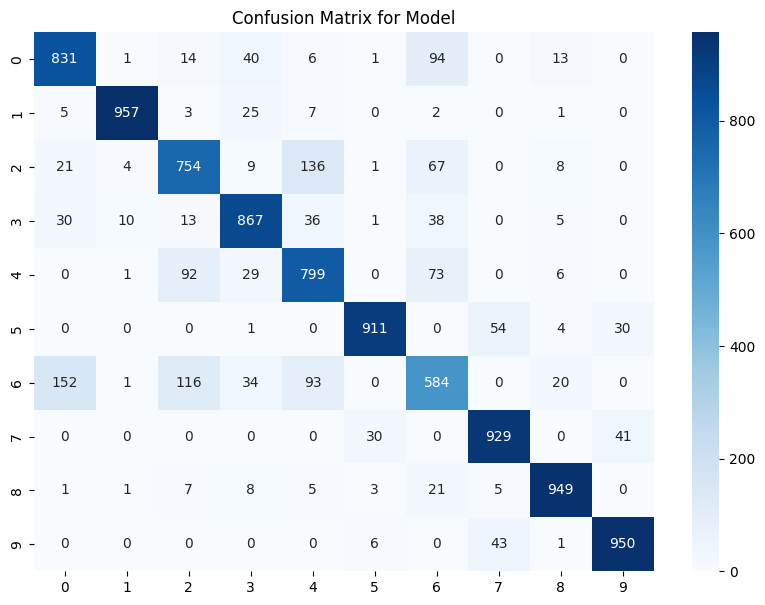

Two classes most confused with each other: Shirt and T-shirt/top


In [14]:
model_trainer.train_manual()
model_trainer.evaluate()
model_trainer.plot_confusion_matrix()

# Q1.2